In [1]:
import sys
import os
from datasets import load_dataset
import numpy as np
from loguru import logger
from pydantic import BaseModel
import plotly.express as px

sys.path.insert(0, '..')
from src.viz import blueq_colors

# Controller

In [2]:
class Args(BaseModel):
    run_name: str = '056-small-rich-dataset'
    testing: bool = True
    notebook_persist_dp: str = None
    random_seed: int = 41

    user_col: str = 'user_id'
    item_col: str = 'parent_asin'
    rating_col: str = 'rating'
    timestamp_col: str = 'timestamp'

    sample_users: int = 1000
    min_user_interactions: int = 5
    min_item_interactions: int = 10

    def init(self):
        self.notebook_persist_dp = os.path.abspath(f"data/{self.run_name}")
        if not self.testing:
            os.makedirs(self.notebook_persist_dp, exist_ok=True)

        return self
    
args = Args().init()

print(args.model_dump_json(indent=2))

{
  "run_name": "056-small-rich-dataset",
  "testing": true,
  "notebook_persist_dp": "/Users/dvq/frostmourne/reco-algo/notebooks/data/056-small-rich-dataset",
  "random_seed": 41,
  "user_col": "user_id",
  "item_col": "parent_asin",
  "rating_col": "rating",
  "timestamp_col": "timestamp",
  "sample_users": 1000,
  "min_user_interactions": 5,
  "min_item_interactions": 10
}


# Load data

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "5core_timestamp_Video_Games", trust_remote_code=True)

In [4]:
dataset['train']

Dataset({
    features: ['user_id', 'parent_asin', 'rating', 'timestamp'],
    num_rows: 736827
})

In [5]:
dataset['valid']

Dataset({
    features: ['user_id', 'parent_asin', 'rating', 'timestamp'],
    num_rows: 34510
})

In [6]:
def parse_dtype(df):
    return (
        df
        .assign(
            rating=lambda df: df[args.rating_col].astype(float),
            timestamp=lambda df: df[args.timestamp_col].astype(int)
        )
    )

train_raw = dataset['train'].to_pandas().pipe(parse_dtype)
val_raw = dataset['valid'].to_pandas().pipe(parse_dtype)

# Sample

In [7]:
from functools import partial

def remove_random_users(df, k=10):
    users = df[args.user_col].unique()
    np.random.seed(args.random_seed)
    to_remove_users = np.random.choice(users, size=k, replace=False)
    return df.loc[lambda df: ~df[args.user_col].isin(to_remove_users)]

def get_unqualified(df, col: str, threshold: int):
    unqualified = df.groupby(col).size().loc[lambda s: s < threshold].index
    return unqualified

get_unqualified_users = partial(get_unqualified, col=args.user_col, threshold=args.min_user_interactions)
get_unqualified_items = partial(get_unqualified, col=args.item_col, threshold=args.min_item_interactions)

In [8]:
sample_df = train_raw.copy()

In [9]:
buffer_perc = 0.2
perc_users_removed_each_round = 0.05
debug = False
min_val_records = 500

keep_random_removing = True
r = 1

while keep_random_removing:
    num_users_removed_each_round = int(perc_users_removed_each_round * sample_df[args.user_col].nunique())
    print(f"\n\nRandomly removing {num_users_removed_each_round} users - Round {r} started")
    new_sample_df = remove_random_users(sample_df, k=num_users_removed_each_round)

    keep_removing = True
    i = 1
    
    while keep_removing:
        if debug: logger.info(f"Sampling round {i} started")
        keep_removing = False
        uu = get_unqualified_users(new_sample_df)
        if debug: logger.info(f"{len(uu)=}")
        if len(uu):
            new_sample_df = new_sample_df.loc[lambda df: ~df[args.user_col].isin(uu)]
            if debug: logger.info(f"After removing uu: {len(new_sample_df)=}")
            assert len(get_unqualified_users(new_sample_df)) == 0
            keep_removing = True
        ui = get_unqualified_items(new_sample_df)
        if debug: logger.info(f"{len(ui)=}")
        if len(ui):
            new_sample_df = new_sample_df.loc[lambda df: ~df[args.item_col].isin(ui)]
            if debug: logger.info(f"After removing ui: {len(new_sample_df)=}")
            assert len(get_unqualified_items(new_sample_df)) == 0
            keep_removing = True
        i += 1

    sample_users = sample_df[args.user_col].unique()
    sample_items = sample_df[args.item_col].unique()
    num_users = len(sample_users)
    logger.info(f"After randomly removing users - round {r}: {num_users=}")
    if num_users > args.sample_users * (1 + buffer_perc):
        logger.info(f"Number of users {num_users} are still greater than expected, keep removing...")
        sample_df = new_sample_df.copy()
    else:
        logger.info(f"Number of users {num_users} are falling below expected threshold, stop and use `sample_df` as final output...")
        keep_random_removing = False

    val_sample_df = val_raw.loc[lambda df: df[args.user_col].isin(sample_users) & df[args.item_col].isin(sample_items)]
    if (num_val_records:=val_sample_df.shape[0]) < min_val_records:
        logger.info(f"Number of val_df records {num_val_records} are falling below expected threshold, stop and use `sample_df` as final output...")
        keep_random_removing = False

    r += 1



Randomly removing 4578 users - Round 1 started


2024-09-20 18:55:56.464 | INFO     | __main__:<module>:39 - After randomly removing users - round 1: num_users=91562
2024-09-20 18:55:56.465 | INFO     | __main__:<module>:41 - Number of users 91562 are still greater than expected, keep removing...




Randomly removing 3216 users - Round 2 started


2024-09-20 18:55:57.134 | INFO     | __main__:<module>:39 - After randomly removing users - round 2: num_users=64329
2024-09-20 18:55:57.134 | INFO     | __main__:<module>:41 - Number of users 64329 are still greater than expected, keep removing...




Randomly removing 3020 users - Round 3 started


2024-09-20 18:55:57.942 | INFO     | __main__:<module>:39 - After randomly removing users - round 3: num_users=60404
2024-09-20 18:55:57.942 | INFO     | __main__:<module>:41 - Number of users 60404 are still greater than expected, keep removing...




Randomly removing 2827 users - Round 4 started


2024-09-20 18:55:58.821 | INFO     | __main__:<module>:39 - After randomly removing users - round 4: num_users=56541
2024-09-20 18:55:58.821 | INFO     | __main__:<module>:41 - Number of users 56541 are still greater than expected, keep removing...




Randomly removing 2649 users - Round 5 started


2024-09-20 18:55:59.511 | INFO     | __main__:<module>:39 - After randomly removing users - round 5: num_users=52996
2024-09-20 18:55:59.511 | INFO     | __main__:<module>:41 - Number of users 52996 are still greater than expected, keep removing...




Randomly removing 2476 users - Round 6 started


2024-09-20 18:56:00.386 | INFO     | __main__:<module>:39 - After randomly removing users - round 6: num_users=49529
2024-09-20 18:56:00.386 | INFO     | __main__:<module>:41 - Number of users 49529 are still greater than expected, keep removing...




Randomly removing 2318 users - Round 7 started


2024-09-20 18:56:01.021 | INFO     | __main__:<module>:39 - After randomly removing users - round 7: num_users=46368
2024-09-20 18:56:01.021 | INFO     | __main__:<module>:41 - Number of users 46368 are still greater than expected, keep removing...




Randomly removing 2173 users - Round 8 started


2024-09-20 18:56:01.597 | INFO     | __main__:<module>:39 - After randomly removing users - round 8: num_users=43471
2024-09-20 18:56:01.598 | INFO     | __main__:<module>:41 - Number of users 43471 are still greater than expected, keep removing...




Randomly removing 2031 users - Round 9 started


2024-09-20 18:56:02.229 | INFO     | __main__:<module>:39 - After randomly removing users - round 9: num_users=40631
2024-09-20 18:56:02.230 | INFO     | __main__:<module>:41 - Number of users 40631 are still greater than expected, keep removing...




Randomly removing 1895 users - Round 10 started


2024-09-20 18:56:02.717 | INFO     | __main__:<module>:39 - After randomly removing users - round 10: num_users=37910
2024-09-20 18:56:02.718 | INFO     | __main__:<module>:41 - Number of users 37910 are still greater than expected, keep removing...




Randomly removing 1770 users - Round 11 started


2024-09-20 18:56:03.255 | INFO     | __main__:<module>:39 - After randomly removing users - round 11: num_users=35402
2024-09-20 18:56:03.255 | INFO     | __main__:<module>:41 - Number of users 35402 are still greater than expected, keep removing...




Randomly removing 1649 users - Round 12 started


2024-09-20 18:56:03.682 | INFO     | __main__:<module>:39 - After randomly removing users - round 12: num_users=32984
2024-09-20 18:56:03.682 | INFO     | __main__:<module>:41 - Number of users 32984 are still greater than expected, keep removing...




Randomly removing 1534 users - Round 13 started


2024-09-20 18:56:04.219 | INFO     | __main__:<module>:39 - After randomly removing users - round 13: num_users=30682
2024-09-20 18:56:04.220 | INFO     | __main__:<module>:41 - Number of users 30682 are still greater than expected, keep removing...




Randomly removing 1430 users - Round 14 started


2024-09-20 18:56:04.675 | INFO     | __main__:<module>:39 - After randomly removing users - round 14: num_users=28616
2024-09-20 18:56:04.675 | INFO     | __main__:<module>:41 - Number of users 28616 are still greater than expected, keep removing...




Randomly removing 1335 users - Round 15 started


2024-09-20 18:56:04.983 | INFO     | __main__:<module>:39 - After randomly removing users - round 15: num_users=26714
2024-09-20 18:56:04.983 | INFO     | __main__:<module>:41 - Number of users 26714 are still greater than expected, keep removing...




Randomly removing 1245 users - Round 16 started


2024-09-20 18:56:05.421 | INFO     | __main__:<module>:39 - After randomly removing users - round 16: num_users=24904
2024-09-20 18:56:05.421 | INFO     | __main__:<module>:41 - Number of users 24904 are still greater than expected, keep removing...




Randomly removing 1152 users - Round 17 started


2024-09-20 18:56:05.827 | INFO     | __main__:<module>:39 - After randomly removing users - round 17: num_users=23056
2024-09-20 18:56:05.827 | INFO     | __main__:<module>:41 - Number of users 23056 are still greater than expected, keep removing...




Randomly removing 1068 users - Round 18 started


2024-09-20 18:56:06.099 | INFO     | __main__:<module>:39 - After randomly removing users - round 18: num_users=21365
2024-09-20 18:56:06.099 | INFO     | __main__:<module>:41 - Number of users 21365 are still greater than expected, keep removing...




Randomly removing 992 users - Round 19 started


2024-09-20 18:56:06.357 | INFO     | __main__:<module>:39 - After randomly removing users - round 19: num_users=19850
2024-09-20 18:56:06.357 | INFO     | __main__:<module>:41 - Number of users 19850 are still greater than expected, keep removing...




Randomly removing 919 users - Round 20 started


2024-09-20 18:56:06.639 | INFO     | __main__:<module>:39 - After randomly removing users - round 20: num_users=18382
2024-09-20 18:56:06.639 | INFO     | __main__:<module>:41 - Number of users 18382 are still greater than expected, keep removing...




Randomly removing 850 users - Round 21 started


2024-09-20 18:56:06.944 | INFO     | __main__:<module>:39 - After randomly removing users - round 21: num_users=17010
2024-09-20 18:56:06.944 | INFO     | __main__:<module>:41 - Number of users 17010 are still greater than expected, keep removing...
2024-09-20 18:56:07.159 | INFO     | __main__:<module>:39 - After randomly removing users - round 22: num_users=15641




Randomly removing 782 users - Round 22 started


2024-09-20 18:56:07.159 | INFO     | __main__:<module>:41 - Number of users 15641 are still greater than expected, keep removing...
2024-09-20 18:56:07.352 | INFO     | __main__:<module>:39 - After randomly removing users - round 23: num_users=14494
2024-09-20 18:56:07.352 | INFO     | __main__:<module>:41 - Number of users 14494 are still greater than expected, keep removing...




Randomly removing 724 users - Round 23 started


Randomly removing 670 users - Round 24 started


2024-09-20 18:56:07.556 | INFO     | __main__:<module>:39 - After randomly removing users - round 24: num_users=13409
2024-09-20 18:56:07.556 | INFO     | __main__:<module>:41 - Number of users 13409 are still greater than expected, keep removing...
2024-09-20 18:56:07.738 | INFO     | __main__:<module>:39 - After randomly removing users - round 25: num_users=12291
2024-09-20 18:56:07.738 | INFO     | __main__:<module>:41 - Number of users 12291 are still greater than expected, keep removing...




Randomly removing 614 users - Round 25 started


Randomly removing 562 users - Round 26 started


2024-09-20 18:56:07.878 | INFO     | __main__:<module>:39 - After randomly removing users - round 26: num_users=11253
2024-09-20 18:56:07.878 | INFO     | __main__:<module>:41 - Number of users 11253 are still greater than expected, keep removing...
2024-09-20 18:56:07.882 | INFO     | __main__:<module>:49 - Number of val_df records 453 are falling below expected threshold, stop and use `sample_df` as final output...


In [14]:
train_sample_df = sample_df.copy()
sample_users = train_sample_df[args.user_col].unique()
sample_items = train_sample_df[args.item_col].unique()
logger.info(f"{len(sample_users)=} {len(sample_items)=}")

val_sample_df = val_raw.loc[lambda df: df[args.user_col].isin(sample_users) & df[args.item_col].isin(sample_items)]

train_items = train_sample_df[args.item_col].unique()
train_users = train_sample_df[args.user_col].unique()
val_items = val_sample_df[args.item_col].unique()
val_users = val_sample_df[args.user_col].unique()

2024-09-20 18:56:15.700 | INFO     | __main__:<module>:4 - len(sample_users)=10371 len(sample_items)=2794


In [15]:
logger.info(f"{len(train_items)=}, {len(train_users)=}")
logger.info(f"{len(val_items)=}, {len(val_users)=}")
val_users_in_train = set(val_users).intersection(set(train_users))
val_items_in_train = set(val_items).intersection(set(train_items))
logger.info(f"Percentage of val users in train: {len(val_users_in_train) / len(val_users):,.0%}")
logger.info(f"Percentage of val items in train: {len(val_items_in_train) / len(val_items):,.0%}")
logger.info(f"Sparsity: {1 - len(train_sample_df) / (len(train_items) * len(train_users)):,.4%}")

2024-09-20 18:56:16.654 | INFO     | __main__:<module>:1 - len(train_items)=2794, len(train_users)=10371
2024-09-20 18:56:16.655 | INFO     | __main__:<module>:2 - len(val_items)=264, len(val_users)=309
2024-09-20 18:56:16.660 | INFO     | __main__:<module>:5 - Percentage of val users in train: 100%
2024-09-20 18:56:16.661 | INFO     | __main__:<module>:6 - Percentage of val items in train: 100%
2024-09-20 18:56:16.662 | INFO     | __main__:<module>:7 - Sparsity: 99.7073%


# Sample data

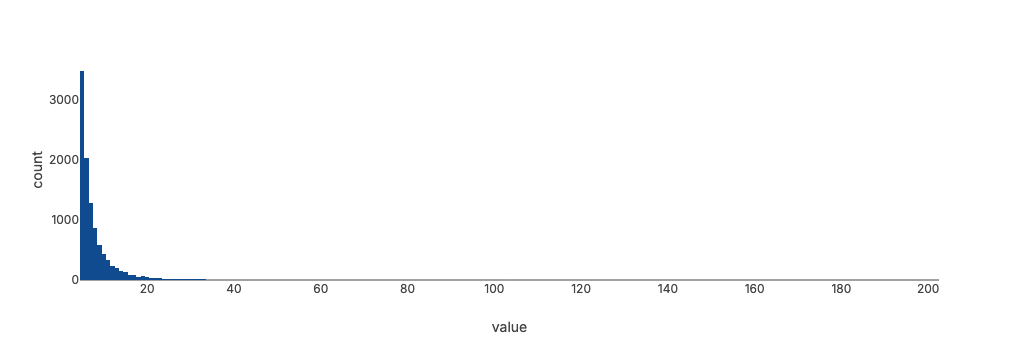

In [18]:
px.histogram(train_sample_df.groupby(args.user_col).size())

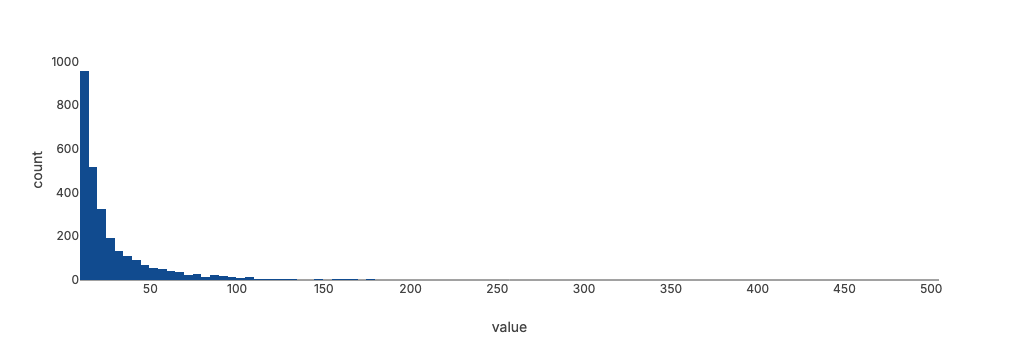

In [19]:
px.histogram(train_sample_df.groupby(args.item_col).size())

In [20]:
train_sample_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,84819,10371,AGMWACNMAG74AXBF7IJ22IOZSZPA,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_asin,84819,2794,B0086VPUHI,502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,84819.0,NaN,NaN,NaN,4.303081,1.151557,1.0,4.0,5.0,5.0,5.0
timestamp,84819.0,NaN,NaN,NaN,1432610979641.37793,99757507057.27272,961125766000.0,1386962349000.0,1438209039000.0,1494513134500.0,1628623121511.0


# Persist sample

In [22]:
train_sample_df.to_parquet("../data/train.parquet")
val_sample_df.to_parquet("../data/val.parquet")

# Archive